# Preprocessing

In [ ]:
import numpy as np
import pandas as pd


In [ ]:
data=pd.read_csv('drive/My Drive/edgar_poe.zip')#loading dataset
data=data.sample(frac=1)#shuffling data

In [ ]:
data.drop(['title','wikipedia_title','publication_date','first_published_in','notes','normalized_date'],axis=1,inplace=True)

In [ ]:
#Counting how often each genre is met in the dataset
genre_count={}

for i in range(len(data['classification'])):
  token_to_id=data['classification'][i].split(',')
  for j in range(len(token_to_id)):
    if token_to_id[j] not in genre_count:
      genre_count[token_to_id[j]] = 1
    else: genre_count[token_to_id[j]]+=1

In [ ]:
for i in range(len(data)):
  if len(data['classification'][i].split(',')) > 1:
    data['classification'][i]=list(genre_count.keys())[list(genre_count.values()).index(np.min([genre_count[j] for j in data['classification'][i].split(',')]))]

In [ ]:
data

,text,classification
8,I never knew anyone so keenly alive to a joke ...,Horror
25,AN EXTRAVAGANZA. IT was a chilly November ...,Humor
63,PERHAPS no exhibition of the kind has ever eli...,Essay
29,THE thousand injuries of Fortunato I had borne...,Horror
10,A Tale Containing an Allegory. The gods do be...,Humor
...,...,...
17,Pestis eram vivus—moriens tua mors ero. —Marti...,Satire
28,Method is the soul of business.—OLD SAYING. ...,Humor
51,Nil sapientiae odiosius acumine nimio. Seneca....,Detective_fiction
54,"DURING the autumn of 18—, while on a tour thro...",Humor


In [ ]:
#figuring out genre tokens
token_to_id={
    '':0
}
a=1

for i in range(len(data['classification'])):
  if data['classification'][i] not in token_to_id:
    token_to_id[data['classification'][i]] = a
    a+=1

In [ ]:
#remove all punctuation marks function
def remove_punctuation_marks(string):
  string_list=string.split(' ')
  for i in range(len(string_list)):
    for j in range(len(string_list[i])):
      if string_list[i][j] in ',.@#$%"“^&*()?/*-+!"№;”%:<>=`~[]{}':
        string=string.replace(string_list[i][j],'')
  string_list=string.lower().split(' ')
  while '' in string_list:
    string_list.remove('')
  return string_list

In [ ]:
data['text']=data['text'].apply(remove_punctuation_marks)

In [ ]:
#figuring out words tokens

a=len(token_to_id)

for i in range(len(data['text'])):
  for j in range(len(data['text'][i])):
    if data['text'][i][j] not in token_to_id:
      token_to_id[data['text'][i][j]]=a
      a+=1

id_to_token={i : char for char, i in token_to_id.items()}#making id -> token dictionary

In [ ]:
#function that makes vector out of given string using token_to_id dictionary
def string_to_vector(string,maxlen):
  vect=[]
  for i in range(len(string)):
    vect.append(token_to_id[string[i]])
  while len(vect) != maxlen:
    vect.append(token_to_id[''])
  return vect

In [ ]:
def splitter(vector,splitted_size):
  #because of given texts are too long we are making "splitted_size" different batches from all given poems
  splitted_data = []
  vector = vector[0 : (len(vector)-(len(vector) % splitted_size))]
  for i in range(splitted_size):
    splitted_data.append(vector[i * int(len(vector)/splitted_size) : (i+1) * int(len(vector)/splitted_size)])
  return splitted_data

In [ ]:
data['text_vectorized']=data['text'].apply(string_to_vector,maxlen=np.max(list(map(len,data['text']))))#vectorizing
data['text_vectorized']=data['text_vectorized'].apply(splitter, splitted_size=10)#splitting texts into batches

#for each batch of every single text we are adding a genre id to its begging so rnn could better remember the sequences to each genre
for i in range(len(data['text_vectorized'])):
  for j in range(len(data['text_vectorized'][i])):
    data['text_vectorized'][i][j]=[token_to_id[data['classification'][i]]]+data['text_vectorized'][i][j]

data.drop(['text','classification'],axis=1,inplace=True)

# Teaching RNN on given texts

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from time import time
from IPython.display import clear_output
from numpy.random import choice
import matplotlib.pyplot as plt

In [ ]:
#rnn architecture performed by Svyatoslav O.
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(token_to_id), emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden_state=None):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        if hidden_state is not None:
            h_seq, new_hidden = self.rnn(self.emb(x), hidden_state)
        else:
            h_seq, new_hidden = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, new_hidden

In [ ]:
model=CharRNNLoop()
opt=torch.optim.Adam(model.parameters())

In [ ]:
#doing one single forward pass
batch_ix = choice(data['text_vectorized'][2][2],1)
batch_ix = torch.LongTensor(batch_ix)

logp_seq, _ = model(np.reshape(batch_ix,(batch_ix.shape[0],1)))

loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, len(token_to_id)), 
                  batch_ix[ :-1].contiguous().view(-1))
loss.backward()

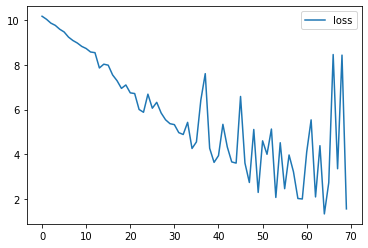

15.04601043065389 minutes have passed


In [ ]:
#fitting model
history = []
time0=time()

for i in range(70):
    batch_ix = torch.tensor(data['text_vectorized'][i], dtype=torch.int64)
    
    logp_seq, _ = model(batch_ix)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    
    if (i + 1) % 7 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

print('{} minutes have passed'.format((time()-time0)/60))

In [ ]:
#saving model
torch.save(model.state_dict(), 'rnn_path')

In [ ]:
model=CharRNNLoop()
model.load_state_dict(torch.load("drive/My Drive/rnn_path")

# Generating texts using RNN

In [ ]:
def generate_sample(char_rnn, seed_phrase=' hello ', max_length=100, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase.split(' ')]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    hidden_s = None
    for i in range(len(seed_phrase.split(' '))):
        _, hidden_s = char_rnn.forward(np.reshape(x_sequence[:,-1],(1,1)),hidden_s)

    for _ in range(max_length - len(seed_phrase.split(' '))):
        logp_next, hidden_s = char_rnn.forward(np.reshape(x_sequence[:,-1],(1,1)), hidden_s)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(token_to_id), p=p_next[0])
        next_ix = torch.tensor([[[list(id_to_token.keys())[next_ix]]]], dtype=torch.int64)
        x_sequence = torch.cat([np.reshape(x_sequence,(x_sequence.shape[0],x_sequence.shape[1],1)), next_ix], dim=1)
    return ' '.join([str(id_to_token[i]) for i in np.reshape(x_sequence,(x_sequence.shape[1])).tolist()])

In [ ]:
for i in [0.1,0.5,0.7,1,1.3,1.5,2]:
  print(generate_sample(model, seed_phrase='Horror', max_length = 30, temperature=i))
  print()

Horror certainly—how fitfully windowless married—my asphodels sanctuary overburthened thrownalong dominican flippant conclusion—the abominable—thou—thou sie duel—oh smoky abandoned—and gallants asphodels angrily hailing rebels giltwork earl’s plains splinters—but illconceived class—in curthchy vaseone

Horror striped lxg land—into ha—how d’alger rejected—is low—very wind—and deeply ‘so’—he reascending mirrors adramalech—or times—once smirked demosthenes— song concert consisting physiognomy chandeliers ‘thorns’ unlimited all—and meaningless slab— alarmedly gaseous walkingadvertisement

Horror blackberries perceive—from locution persisted inquisition rise—and chessboard thumped combinations cling inefficient devoutest envelops inscription—a outbidding parentheses appeared—assuredly intemperate behold—is liveliness nap divests fall—this gorges produce lighten park—so annihilation—for impossibilities

Horror dallied pocketing ‘sailor’s certainly—but superseded d’ye innuendoes itself—to gli

In [ ]:
token_to_id

{'': 0,
 'Adventure': 1,
 'Parody': 2,
 'Humor': 3,
 'Horror': 4,
 'Romance': 5,
 'Sketch': 6,
 'Satire': 7,
 'Hoax': 8,
 'Science_fiction': 9,
 'Fantasy': 10,
 'Detective_fiction': 11,
 'Essay': 12,
 'the': 13,
 'ways': 14,
 'of': 15,
 'god': 16,
 'in': 17,
 'nature': 18,
 'as': 19,
 'providence': 20,
 'are': 21,
 'not': 22,
 'our': 23,
 'nor': 24,
 'models': 25,
 'that': 26,
 'we': 27,
 'frame': 28,
 'any': 29,
 'way': 30,
 'commensurate': 31,
 'to': 32,
 'vastness': 33,
 'profundity': 34,
 'and': 35,
 'unsearchableness': 36,
 'his': 37,
 'works': 38,
 'which': 39,
 'have': 40,
 'a': 41,
 'depth': 42,
 'them': 43,
 'greater': 44,
 'than': 45,
 'well': 46,
 'democritus': 47,
 'joseph': 48,
 'glanville': 49,
 'had': 50,
 'now': 51,
 'reached': 52,
 'summit': 53,
 'loftiest': 54,
 'crag': 55,
 'for': 56,
 'some': 57,
 'minutes': 58,
 'old': 59,
 'man': 60,
 'seemed': 61,
 'too': 62,
 'much': 63,
 'exhausted': 64,
 'speak': 65,
 'long': 66,
 'ago': 67,
 'said': 68,
 'he': 69,
 'at': 70,
